# Forcasting Air Quality of Relative Humidity
![ap](ap.jpeg)
## Introduction:
The dataset contains 9358 instances of hourly averaged responses from an array of 5 metal oxide chemical sensors embedded in an Air Quality Chemical Multisensor Device. The device was located on the field in a significantly polluted area, at road level,within an Italian city. Data were recorded from March 2004 to February 2005 (one year)representing the longest freely available recordings of on field deployed air quality chemical sensor devices responses. Ground Truth hourly averaged concentrations for CO, Non Metanic Hydrocarbons, Benzene, Total Nitrogen Oxides (NOx) and Nitrogen Dioxide (NO2) and were provided by a co-located reference certified analyzer. Evidences of cross-sensitivities as well as both concept and sensor drifts are present as described in De Vito et al., Sens. And Act. B, Vol. 129,2,2008 (citation required) eventually affecting sensors concentration estimation capabilities. 
- Missing values are tagged with -200 value.

### Data Dictionary

|Index|Name|Details|
|:---:|:--|:-----|
|0| Date| (DD/MM/YYYY)|
|1| Time| (HH.MM.SS)|
|2| CO(GT)| True hourly averaged concentration CO in mg/m^3 (reference analyzer)|
|3| PT08.S1(CO)| (tin oxide) hourly averaged sensor response (nominally CO targeted)|
|4| NMHC(GT)| True hourly averaged overall Non Metanic HydroCarbons concentration in microg/m^3 (reference analyzer)|
|5| C6H6(GT)| True hourly averaged Benzene concentration in microg/m^3 (reference analyzer)|
|6| PT08.S2(NMHC)| (titania) hourly averaged sensor response (nominally NMHC targeted)|
|7| NOx(GT)| True hourly averaged NOx concentration in ppb (reference analyzer)|
|8| PT08.S3(NOx)| (tungsten oxide) hourly averaged sensor response (nominally NOx targeted)|
|9| NO2(GT)| True hourly averaged NO2 concentration in microg/m^3 (reference analyzer)|
|10| PT08.S4(NO2)| (tungsten oxide) hourly averaged sensor response (nominally NO2 targeted)|
|11| PT08.S5(O3)| (indium oxide) hourly averaged sensor response (nominally O3 targeted)|
|12| T| Temperature in Â°C|
|13| **RH**| **Relative Humidity (%)**|
|14| AH| Absolute Humidity|

### Goal

We will predict the Relative Humidity of a given point of time based on the all other attributes affecting the change in `RH`.

### Resources:
Saverio De Vito, ENEA - National Agency for New Technologies, Energy and Sustainable Economic Development
- [Saverio De Vito's contact](saverio.devito@enea.it)



In [1]:
# Importing Libraries
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Import Prophet for TimeSeries Forecasting
from prophet import Prophet
import logging

logging.getLogger().setLevel(logging.ERROR)


In [2]:
data = pd.read_csv('airqualdata.csv', sep=';')

In [3]:
data.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Unnamed: 15,Unnamed: 16
0,10/03/2004,18.00.00,"2,6",1360.0,150.0,"11,9",1046.0,166.0,1056.0,113.0,1692.0,1268.0,"13,6","48,9","0,7578",NaN,NaN
1,10/03/2004,19.00.00,2,1292.0,112.0,"9,4",955.0,103.0,1174.0,92.0,1559.0,972.0,"13,3","47,7","0,7255",NaN,NaN
2,10/03/2004,20.00.00,"2,2",1402.0,88.0,"9,0",939.0,131.0,1140.0,114.0,1555.0,1074.0,"11,9","54,0","0,7502",NaN,NaN
3,10/03/2004,21.00.00,"2,2",1376.0,80.0,"9,2",948.0,172.0,1092.0,122.0,1584.0,1203.0,"11,0","60,0","0,7867",NaN,NaN
4,10/03/2004,22.00.00,"1,6",1272.0,51.0,"6,5",836.0,131.0,1205.0,116.0,1490.0,1110.0,"11,2","59,6","0,7888",NaN,NaN


## Data Cleaning 

In [4]:
data.shape

(9471, 17)

In [5]:
data.isnull().sum()

Date              114
Time              114
CO(GT)            114
PT08.S1(CO)       114
NMHC(GT)          114
C6H6(GT)          114
PT08.S2(NMHC)     114
NOx(GT)           114
PT08.S3(NOx)      114
NO2(GT)           114
PT08.S4(NO2)      114
PT08.S5(O3)       114
T                 114
RH                114
AH                114
Unnamed: 15      9471
Unnamed: 16      9471
dtype: int64

- For now, lets delete all the rows and columns with null values

In [6]:
data = data.dropna(how='all', axis=0)
data = data.dropna(how='all', axis=1)

In [7]:
data.shape

(9357, 15)

In [8]:
data.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,10/03/2004,18.00.00,"2,6",1360.0,150.0,"11,9",1046.0,166.0,1056.0,113.0,1692.0,1268.0,"13,6","48,9","0,7578"
1,10/03/2004,19.00.00,2,1292.0,112.0,"9,4",955.0,103.0,1174.0,92.0,1559.0,972.0,"13,3","47,7","0,7255"
2,10/03/2004,20.00.00,"2,2",1402.0,88.0,"9,0",939.0,131.0,1140.0,114.0,1555.0,1074.0,"11,9","54,0","0,7502"
3,10/03/2004,21.00.00,"2,2",1376.0,80.0,"9,2",948.0,172.0,1092.0,122.0,1584.0,1203.0,"11,0","60,0","0,7867"
4,10/03/2004,22.00.00,"1,6",1272.0,51.0,"6,5",836.0,131.0,1205.0,116.0,1490.0,1110.0,"11,2","59,6","0,7888"


In [9]:
# Adjusting dates dtypes to datetime
data['Date'] = pd.to_datetime(data['Date'])

In [10]:
# There are some measurements in commas, reverting back to decimals
obj_cols = [cols for cols in data.columns if data[cols].dtype == 'object']
for col in data[obj_cols].columns:
    data[col] = data[col].str.replace(',', '.')

In [11]:
obj_cols.remove('Time')
for col in data[obj_cols].columns:
    data[col] = data[col].astype(float)

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9357 entries, 0 to 9356
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           9357 non-null   datetime64[ns]
 1   Time           9357 non-null   object        
 2   CO(GT)         9357 non-null   float64       
 3   PT08.S1(CO)    9357 non-null   float64       
 4   NMHC(GT)       9357 non-null   float64       
 5   C6H6(GT)       9357 non-null   float64       
 6   PT08.S2(NMHC)  9357 non-null   float64       
 7   NOx(GT)        9357 non-null   float64       
 8   PT08.S3(NOx)   9357 non-null   float64       
 9   NO2(GT)        9357 non-null   float64       
 10  PT08.S4(NO2)   9357 non-null   float64       
 11  PT08.S5(O3)    9357 non-null   float64       
 12  T              9357 non-null   float64       
 13  RH             9357 non-null   float64       
 14  AH             9357 non-null   float64       
dtypes: datetime64[ns](1),

## Feature Engineering 

In [13]:
# Compute the average considering only the positive values
def positive_average(ser):
    return ser[ser > -200].mean()

# Aggregate data
daily_data = data.drop('Time', axis=1).groupby('Date').apply(positive_average)

In [14]:
daily_data

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
Date,,,,,,,,,,,,,
2004-01-04,2.550000,1244.380952,310.125,11.971429,1010.428571,161.304348,880.666667,96.739130,1644.380952,1155.857143,15.519048,51.133333,0.854881
2004-01-05,2.056522,1097.500000,275.000,8.662500,913.708333,104.739130,918.083333,84.956522,1640.416667,904.625000,20.150000,52.183333,1.167312
2004-01-06,2.100000,1135.583333,NaN,12.375000,1021.875000,152.043478,896.791667,75.869565,1881.500000,1066.958333,20.325000,66.154167,1.533350
2004-01-07,2.162500,1130.583333,NaN,12.225000,1038.541667,139.695652,740.916667,113.434783,1854.250000,1059.625000,30.450000,39.691667,1.624108
2004-01-08,0.983333,974.166667,NaN,5.808333,792.583333,51.739130,880.083333,58.521739,1559.000000,670.583333,30.654167,42.120833,1.673521
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2005-11-02,4.162500,1470.666667,NaN,14.133333,1119.000000,607.782609,510.666667,223.347826,1315.666667,2043.666667,7.966667,54.100000,0.579733
2005-11-03,1.682609,1170.260870,NaN,10.365217,955.260870,379.291667,671.130435,159.458333,1195.173913,1216.869565,11.060870,44.769565,0.578513
2005-12-01,3.273913,1301.958333,NaN,15.333333,1135.791667,559.086957,556.166667,148.956522,1489.125000,1456.000000,11.966667,65.687500,0.905333


In [15]:
# Drop columns with more than 8 NaN
daily_data = daily_data.dropna(thresh=daily_data.shape[0]-8, axis=1)

In [16]:
# Remove all the rows
daily_data = daily_data.dropna()
daily_data.head()

,PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),PT08.S3(NOx),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
Date,,,,,,,,,
2004-01-04,1244.380952,11.971429,1010.428571,880.666667,1644.380952,1155.857143,15.519048,51.133333,0.854881
2004-01-05,1097.500000,8.662500,913.708333,918.083333,1640.416667,904.625000,20.150000,52.183333,1.167312
2004-01-06,1135.583333,12.375000,1021.875000,896.791667,1881.500000,1066.958333,20.325000,66.154167,1.533350
2004-01-07,1130.583333,12.225000,1038.541667,740.916667,1854.250000,1059.625000,30.450000,39.691667,1.624108
2004-01-08,974.166667,5.808333,792.583333,880.083333,1559.000000,670.583333,30.654167,42.120833,1.673521


In [17]:
weekly_data = daily_data.resample('W').mean()
weekly_data = weekly_data.dropna()
weekly_data

,PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),PT08.S3(NOx),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
Date,,,,,,,,,
2004-01-04,1244.380952,11.971429,1010.428571,880.666667,1644.380952,1155.857143,15.519048,51.133333,0.854881
2004-01-11,1136.801760,11.674457,1009.344462,760.484990,1727.833075,1083.683747,24.564726,53.224017,1.526858
2004-01-18,1173.375000,13.429167,1050.458333,1490.333333,1448.541667,1196.333333,10.891667,77.000000,1.002796
2004-02-08,1095.033333,9.748333,945.575000,869.108333,1689.916667,937.608333,24.432500,45.753333,1.323161
2004-02-15,1227.406250,16.081250,1133.968750,706.395833,1701.802083,1260.385417,21.717708,57.798958,1.412358
...,...,...,...,...,...,...,...,...,...
2005-09-04,1174.750000,9.068750,904.229167,702.645833,1247.333333,1182.645833,11.891667,54.195833,0.767119
2005-10-02,1279.583333,12.541667,1032.375000,607.708333,1482.916667,1295.875000,13.320833,68.662500,1.044583
2005-10-09,1136.958333,9.937500,947.583333,671.041667,1166.916667,1291.916667,11.266667,46.466667,0.543837


In [18]:
# Plot the weekly concentration of each gas
def plot_data(col):
    plt.figure(figsize=(17, 8))
    plt.plot(weekly_data[col])
    plt.xlabel('Time')
    plt.ylabel(col)
    plt.title(col, y=0.9, weight='bold', alpha=0.6, fontsize=14)
    plt.show()

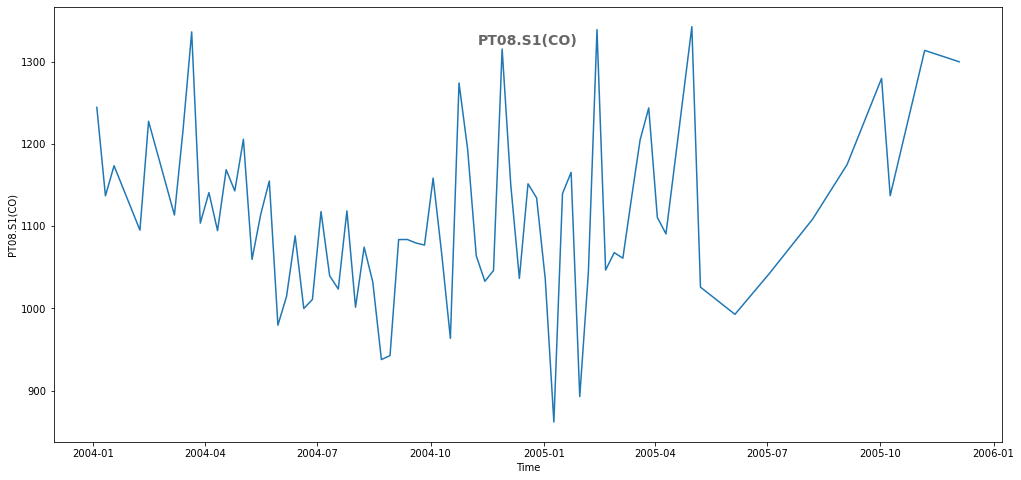

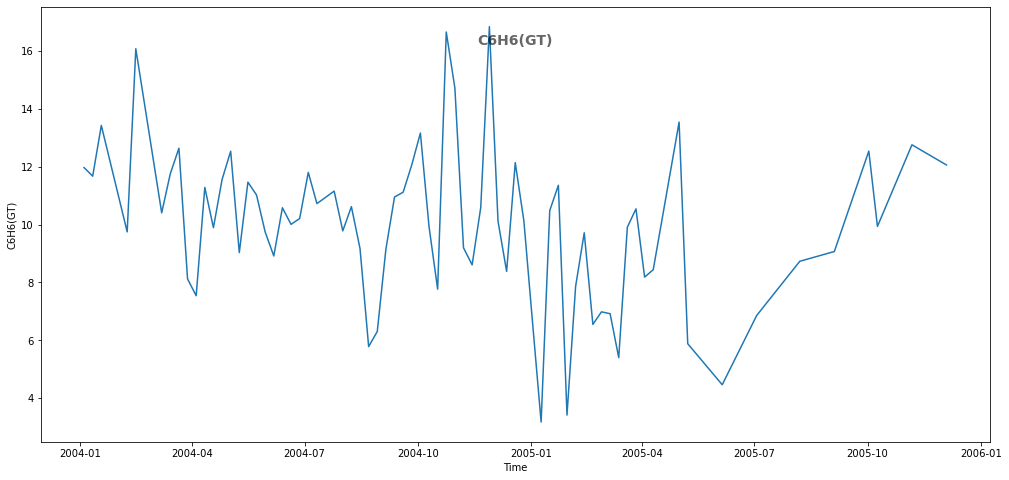

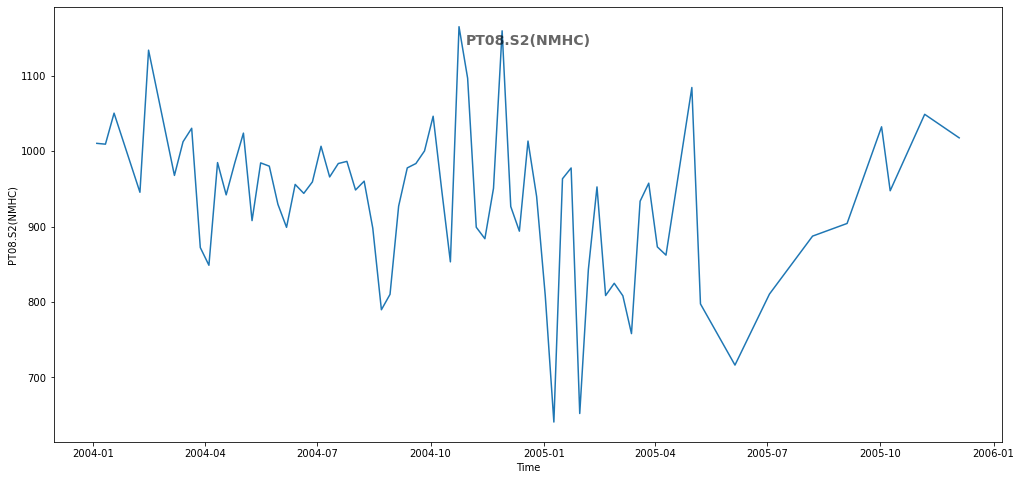

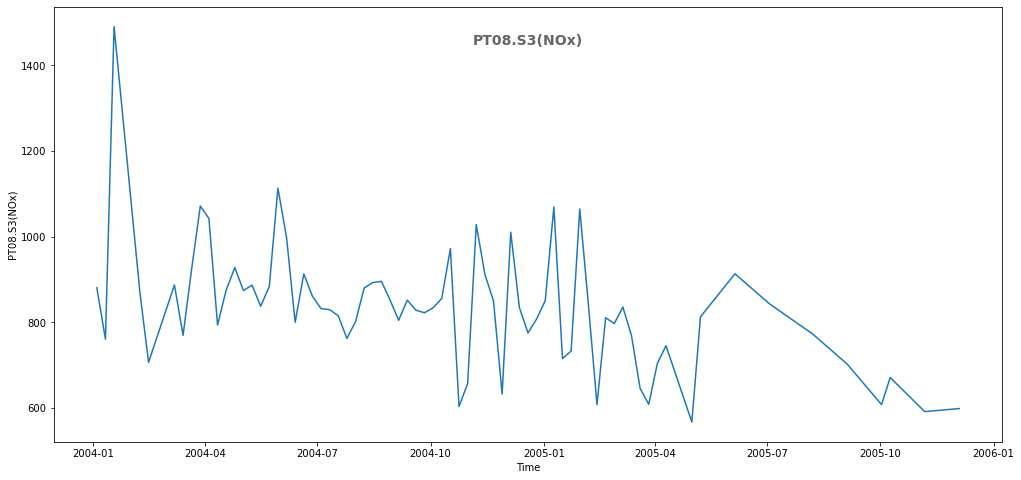

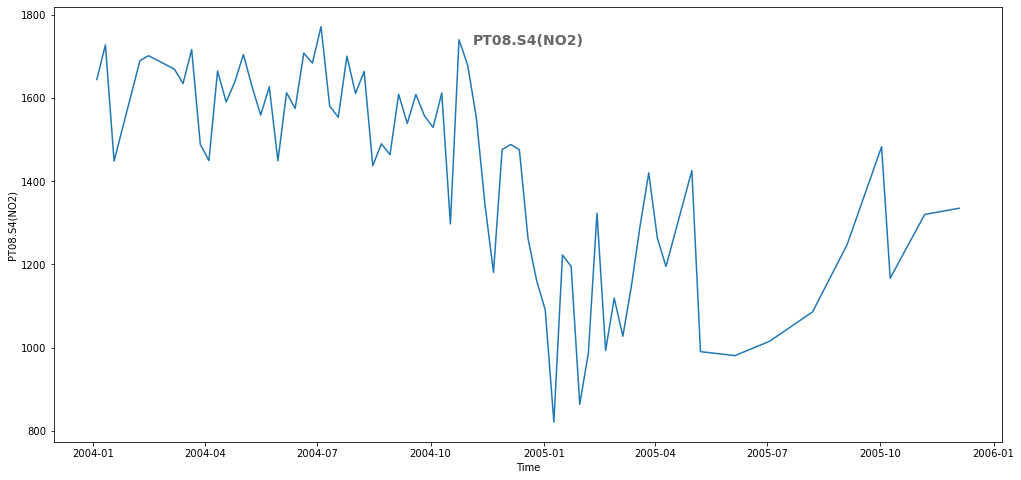

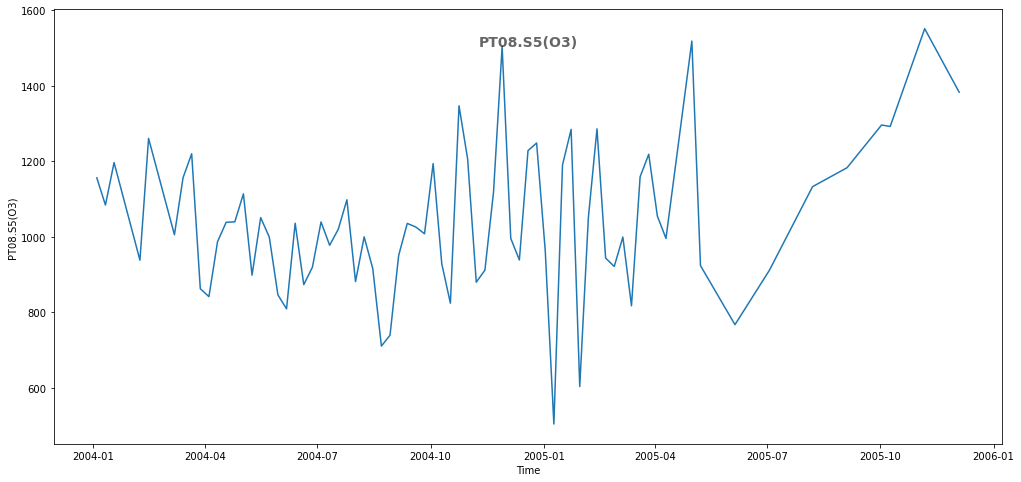

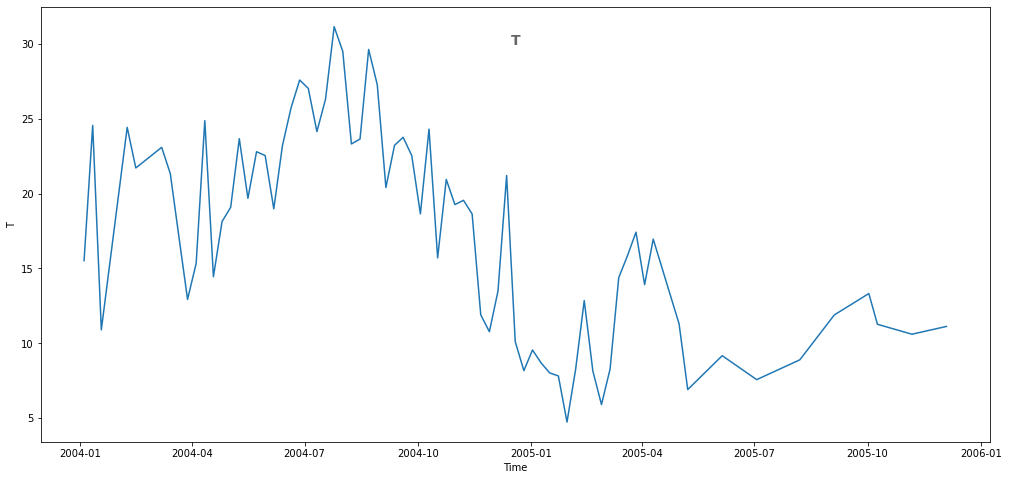

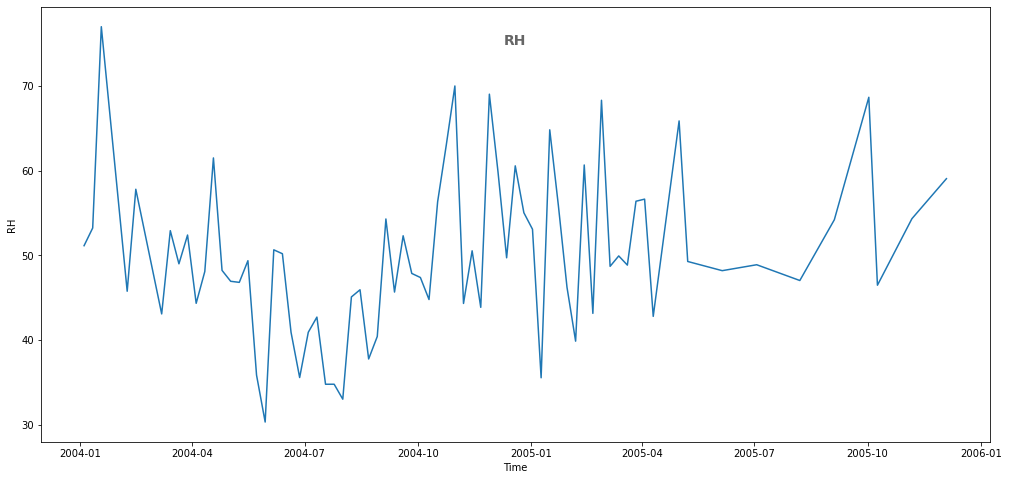

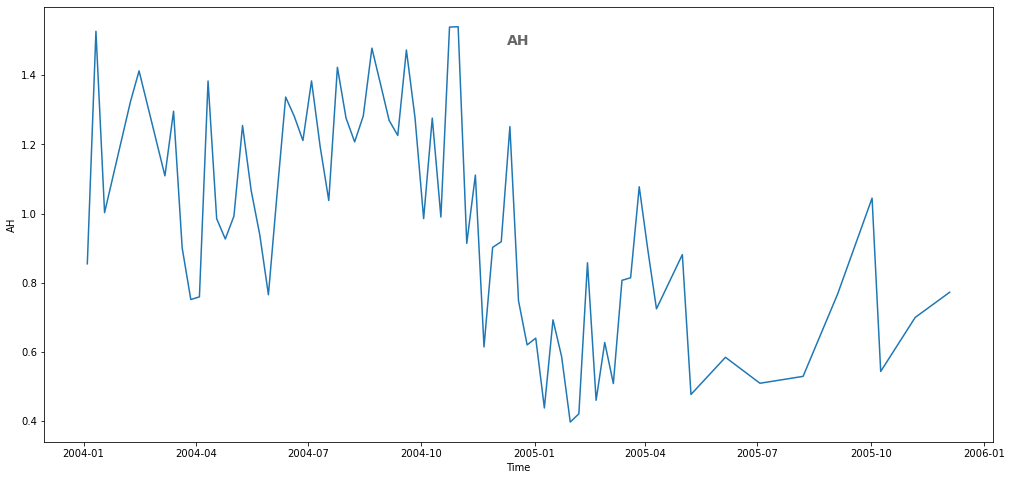

In [19]:
for col in weekly_data.columns:
    plot_data(col)

In [20]:
# Drop irrelevant columns
cols_to_drop = ['PT08.S1(CO)', 'C6H6(GT)', 'PT08.S2(NMHC)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH']
weekly_data = weekly_data.drop(cols_to_drop, axis=1)

In [21]:
weekly_data

,PT08.S3(NOx)
Date,
2004-01-04,880.666667
2004-01-11,760.484990
2004-01-18,1490.333333
2004-02-08,869.108333
2004-02-15,706.395833
...,...
2005-09-04,702.645833
2005-10-02,607.708333
2005-10-09,671.041667


In [22]:
# Change the column names according to Prophet's guidelines
df = weekly_data.reset_index()
df.columns = ['ds', 'y']
df.head()

,ds,y
0,2004-01-04,880.666667
1,2004-01-11,760.484990
2,2004-01-18,1490.333333
3,2004-02-08,869.108333
4,2004-02-15,706.395833


In [23]:
# Split into a train/test set
prediction_size = 30
train_df = df[:-prediction_size]

In [24]:
# Initialize and train a model
m = Prophet()
m.fit(train_df)

17:52:35 - cmdstanpy - INFO - Chain [1] start processing
17:52:35 - cmdstanpy - INFO - Chain [1] done processing


In [25]:
# Make predictions
future = m.make_future_dataframe(periods=prediction_size)
forecast = m.predict(future)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2004-01-04,947.676141,788.803354,1108.000947,947.676141,947.676141,0.0,0.0,0.0,0.0,0.0,0.0,947.676141
1,2004-01-11,944.839401,780.256488,1109.223272,944.839401,944.839401,0.0,0.0,0.0,0.0,0.0,0.0,944.839401
2,2004-01-18,942.002662,772.380975,1117.978814,942.002662,942.002662,0.0,0.0,0.0,0.0,0.0,0.0,942.002662
3,2004-02-08,933.492444,773.076462,1094.947227,933.492444,933.492444,0.0,0.0,0.0,0.0,0.0,0.0,933.492444
4,2004-02-15,930.655705,766.729552,1096.981957,930.655705,930.655705,0.0,0.0,0.0,0.0,0.0,0.0,930.655705


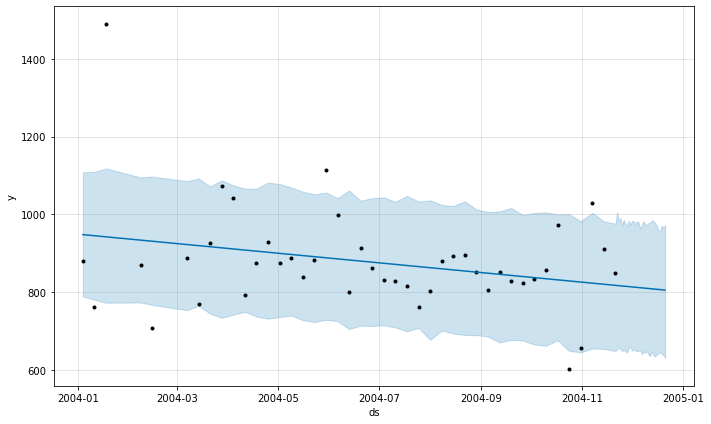

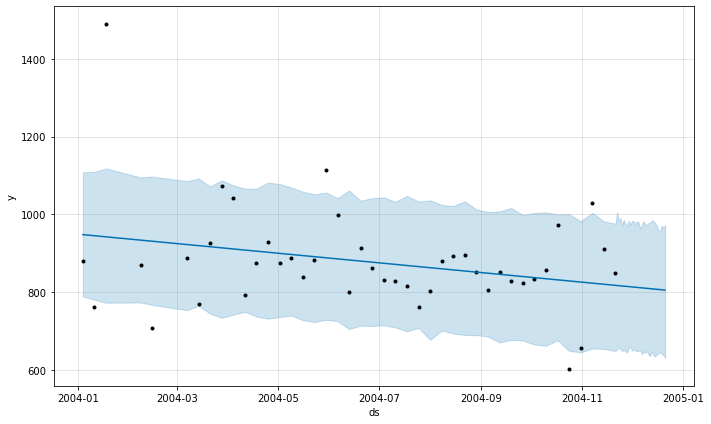

In [26]:
# Plot forecast
m.plot(forecast)

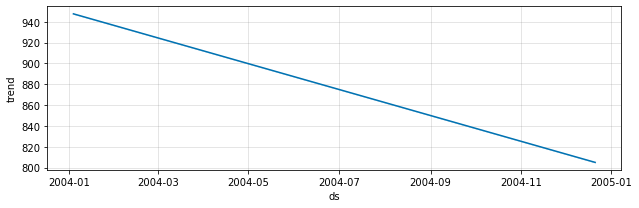

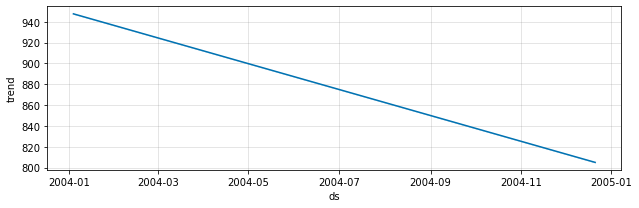

In [27]:
# Plot forecast's components
m.plot_components(forecast)

In [28]:
# Evaluate the model
def make_comparison_dataframe(historical, forecast):
    return forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(historical.set_index('ds'))

In [29]:
cmp_df = make_comparison_dataframe(df, forecast)
cmp_df.head()

,yhat,yhat_lower,yhat_upper,y
ds,,,,
2004-01-04,947.676141,788.803354,1108.000947,880.666667
2004-01-11,944.839401,780.256488,1109.223272,760.484990
2004-01-18,942.002662,772.380975,1117.978814,1490.333333
2004-02-08,933.492444,773.076462,1094.947227,869.108333
2004-02-15,930.655705,766.729552,1096.981957,706.395833


In [30]:
def calculate_forecast_errors(df, prediction_size):
    df = df.copy()
    
    df['e'] = df['y'] - df['yhat']
    df['p'] = 100 * df['e'] / df['y']
    
    predicted_part = df[-prediction_size:]
    
    error_mean = lambda error_name: np.mean(np.abs(predicted_part[error_name]))
    
    return {'MAPE': error_mean('p'), 'MAE': error_mean('e')}

In [31]:
for err_name, err_value in calculate_forecast_errors(cmp_df, prediction_size).items():
    print(err_name, err_value)

MAPE 13.874077771689755
MAE 109.32387955182071


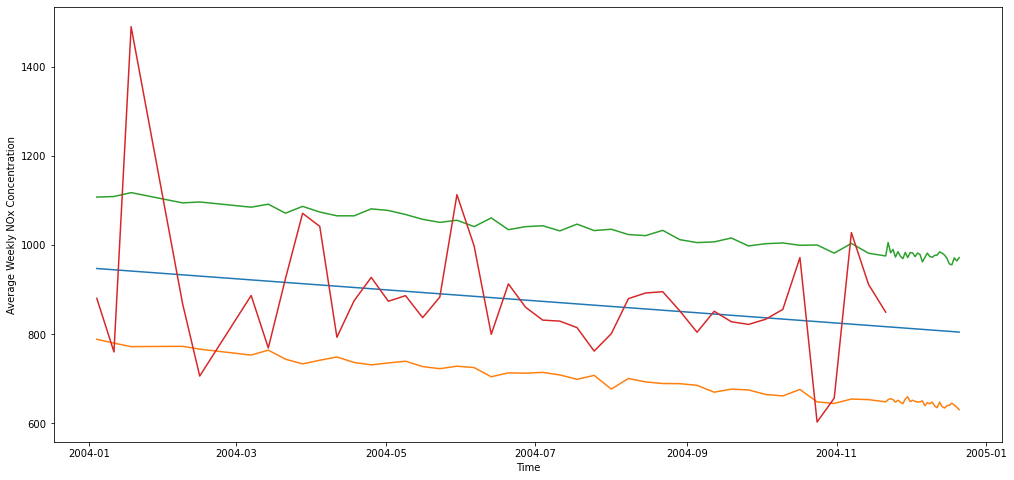

In [32]:
# Plot forecast with upper and lower bounds
plt.figure(figsize=(17, 8))
plt.plot(cmp_df['yhat'])
plt.plot(cmp_df['yhat_lower'])
plt.plot(cmp_df['yhat_upper'])
plt.plot(cmp_df['y'])
plt.xlabel('Time')
plt.ylabel('Average Weekly NOx Concentration')
plt.grid(False)
plt.show()